In [1]:
import sys
import numpy as np
import math
import moviepy.editor as mp
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2482176/45929032 bytes (5.4%)5177344/45929032 bytes (11.3%)7774208/45929032 bytes (16.9%)10493952/45929032 bytes (22.8%)13230080/45929032 bytes (28.8%)15925248/45929032 bytes (34.7%)18677760/45929032 bytes (40.7%)21454848/45929032 bytes (46.7%)24625152/45929032 bytes (53.6%)27959296/45929032 bytes (60.9%)31498240/45929032 bytes (68.6%)34717696/45929032 bytes (75.6%)

In [2]:
def find_speaking(audio_clip, window_size=15, volume_threshold=0.3):

    num_windows = math.floor(audio_clip.end/window_size)

    window_is_silent = []
    for i in range(num_windows):
        s = audio_clip.subclip(i * window_size, (i + 1) * window_size)
        v = s.max_volume()
        window_is_silent.append(v < volume_threshold)

    start = 0
    end = 0
    speaking_intervals = []
    for i in range(1, len(window_is_silent)):
        if window_is_silent[i - 1] and not window_is_silent[i]:
            start = i * window_size

        if not window_is_silent[i - 1] and window_is_silent[i]:
            end = i * window_size
            new_speaking_interval = [start - 0.25, end + 0.25]
            need_to_merge = len(speaking_intervals) > 0 and new_speaking_interval[0] - 60 <= speaking_intervals[-1][0][1]
            if need_to_merge:
                merged_interval = [speaking_intervals[-1][0][0], new_speaking_interval[1]]
                speaking_intervals[-1] = (merged_interval, new_speaking_interval[1] - speaking_intervals[-1][0][0])
            else:
                element = (new_speaking_interval, new_speaking_interval[1] - new_speaking_interval[0])
                speaking_intervals.append(element)
    if len(speaking_intervals) != 0:
        return speaking_intervals
    else:
        return [([0, audio_clip.duration], audio_clip.duration)]

In [11]:
def find_closet_to_frame(speaking_intervals, start, end): 
    result_start = []
    result_end = []
    if len(speaking_intervals) > 0:
        for i in range(len(speaking_intervals)):
            result_start.append([speaking_intervals[i][0][0], abs(start - speaking_intervals[i][0][0])])
            result_end.append([speaking_intervals[i][0][1], abs(end - speaking_intervals[i][0][1])])
        min_start = min(result_start, key=itemgetter(1))[0]
        min_end = min(result_end, key=itemgetter(1))[0]
        return (min_start, min_end)
    else: 
        raise ValueError("EMPTY SPEAKING INTERVALS")

In [7]:
def get_sec_hours(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def get_sec_minutes(time_str):
    """Get seconds from time."""
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

def get_seconds(str_time):
    if len(str_time.split(':')) == 2:
        return get_sec_minutes(str_time)
    elif len(str_time.split(':')) == 3:
        return get_sec_hours(str_time)
    else:
        return int(str_time)

In [12]:
import pandas as pd
import datetime
df = pd.read_csv('dataset.csv', sep=';',header=None)
diff = pd.read_csv('shot_transition_results.csv', sep=';',header=None)

names = []
begin = []
end = []
correct_start = []
correct_end = []
diff_start1 = []
diff_end1 = []

print('=======================================')
for i in range(len(df)):
    video_name = 'drive/MyDrive/dataset/' + df.values[i][0]
    diff_start1.append(int(diff.values[i][2]) - int(diff.values[i][0]))
    diff_end1.append(int(diff.values[i][3]) - int(diff.values[i][1]))

    print(df.values[i][0])
    names.append(df.values[i][0])

    print("Correct Answer: ", get_seconds(df.values[i][1]), " - ", get_seconds(df.values[i][2]))
    correct_start.append(get_seconds(df.values[i][1]))
    correct_end.append(get_seconds(df.values[i][2]))

    clip = mp.VideoFileClip(video_name)
    audio = clip.audio

    a = find_speaking(audio)

    print("Frame Answer: ", int(diff.values[i][2]), " - ", int(diff.values[i][3]))
       
    t1, t2 = find_closet_to_frame(a, int(diff.values[i][2]), int(diff.values[i][3]))

    begin.append(t1)
    end.append(t2)
    print("Composition Answer: ", t1, " - ", t2)
    print('=======================================')

2022-03-01 16_12 Параллельное программирование, 3ВШЭ, весна 2022.mp4
Correct Answer:  900  -  9844
Frame Answer:  860  -  9873
Composition Answer:  869.75  -  9060.25
2022-04-19 16_55 ПМИ3 Высокопроизводительные вычисления.mp4
Correct Answer:  2190  -  8410
Frame Answer:  2200  -  8401
Composition Answer:  2159.75  -  5835.25
2022-05-16 19_29 ПМИ3 Высокопроизводительные вычисления.mp4
Correct Answer:  275  -  3885
Frame Answer:  280  -  3872
Composition Answer:  164.75  -  180.25
2022-03-14 14_31 Software Design, лекция, ВШЭ3, весна 2022.mp4
Correct Answer:  550  -  5395
Frame Answer:  20  -  5445
Composition Answer:  509.75  -  5385.25
2022-03-21 14_37 Software Design, лекция, ВШЭ3, весна 2022.mp4
Correct Answer:  270  -  5095
Frame Answer:  220  -  5141
Composition Answer:  224.75  -  5115.25
2022-04-11 14_31 Software Design, лекция, ВШЭ3, весна 2022.mp4
Correct Answer:  845  -  5560
Frame Answer:  20  -  5558
Composition Answer:  689.75  -  5565.25
2022-04-18 14_36 Software Design, 

In [13]:
result_data = np.array([correct_start, correct_end, begin, end])
result_data_transpose = result_data.transpose()
np.savetxt("composition_results.csv", result_data_transpose, fmt="%d", delimiter=";")

In [14]:
diff = pd.read_csv('composition_results.csv', sep=';',header=None)
diff_start = []
start_level = []
diff_end = []
end_level = []
for i in range(len(diff)):
    start_level.append(1)
    diff_start.append(int(diff.values[i][0]) - int(diff.values[i][2]))
    end_level.append(2)
    diff_end.append(int(diff.values[i][1]) - int(diff.values[i][3]))

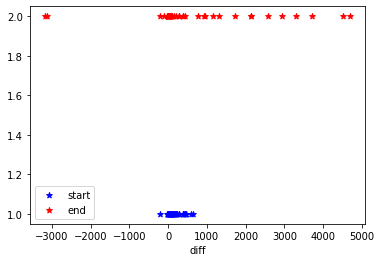

In [15]:
import matplotlib.pyplot as plt
  
plt.scatter(diff_start, start_level, label= "start", color= "blue", 
            marker= "*")

plt.scatter(diff_end, end_level, label= "end", color= "red", 
            marker= "*")
  
plt.xlabel('diff')
plt.legend()
plt.show()